# Kết nối đến drive

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!pip install scikit-learn --upgrade

# Import các thư viện cần thiết

In [28]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.filters import laplace, sobel, roberts
from skimage.feature import canny
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import itertools
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

# Lấy đường dẫn dữ liệu

In [29]:
dataset_dir = '/content/drive/MyDrive/Đồ án CS231.M11/Dataset'
dblurred_dir = os.path.join(dataset_dir,'defocused_blurred')
mblurred_dir = os.path.join(dataset_dir,'motion_blurred')
sharp_dir = os.path.join(dataset_dir,'sharp')

In [30]:
sharp_images = sorted(os.listdir(sharp_dir))
dblurred_images = sorted(os.listdir(dblurred_dir))
mblurred_images = sorted(os.listdir(mblurred_dir))

In [31]:
print(len(sharp_images))
print(len(dblurred_images))
print(len(mblurred_images))

350
350
350


In [32]:
example_img = ['/content/drive/MyDrive/Đồ án CS231.M11/Dataset/defocused_blurred/40_IPHONE-6S_F.jpeg',
               '/content/drive/MyDrive/Đồ án CS231.M11/Dataset/motion_blurred/40_IPHONE-6S_M.jpeg',
               '/content/drive/MyDrive/Đồ án CS231.M11/Dataset/sharp/40_IPHONE-6S_S.jpeg']

# Định nghĩa các hàm cần thiết

In [33]:
def detect_blur_fft(image, size=60, vis=False):
  # Lấy kích thước của hình ảnh để tính tọa độ tâm
  (h, w) = image.shape
  (cX, cY) = (int(w / 2.0), int(h / 2.0))
  # Sử dụng phép dịch để hệ số DC nằm ở giữa ma trận, các điểm biểu diễn tần số tăng dần theo chiều tiến ra biên.
  fft = np.fft.fft2(image)
  fftShift = np.fft.fftshift(fft)

  if vis:
    # Tính toán cường độ quang phổ của phép biến đổi
    magnitude = 20 * np.log(np.abs(fftShift))
    # Show ảnh gốc
    (fig, ax) = plt.subplots(1, 2, )
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Input")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    # Show cường độ quang phổ của ảnh
    ax[1].imshow(magnitude, cmap="gray")
    ax[1].set_title("Magnitude Spectrum")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.show()

  # Loại bỏ tâm của dịch chuyển FFT (loại bỏ tần số thấp) 
  # Áp dụng dịch chuyển nghịch đảo để thành phần DC một lần nữa trở thành trên cùng bên trái, sau đó áp dụng FFT nghịch đảo
  fftShift[cY - size:cY + size, cX - size:cX + size] = 0
  fftShift = np.fft.ifftshift(fftShift)
  recon = np.fft.ifft2(fftShift)

  #Tính toán ma trận cường độ quang phổ của ảnh sau khi xử lý
  magnitude = 20 * np.log(np.abs(recon))

  return magnitude

In [34]:
# Show một số bức ảnh của từng loại
def show_data():
  cols = ['Sharp','Defocused blur','Motion blur']

  fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(20,20))
  for i in range(9):
    sharp_path = os.path.join(sharp_dir,sharp_images[i]);
    dblurred_path = os.path.join(dblurred_dir,dblurred_images[i]);
    mblurred_path = os.path.join(mblurred_dir,mblurred_images[i]);
    sharp_img = cv.imread(sharp_path);
    sharp_img = cv.cvtColor(sharp_img, cv.COLOR_BGR2RGB)
    dblurred_img = cv.imread(dblurred_path);
    dblurred_img = cv.cvtColor(dblurred_img, cv.COLOR_BGR2RGB)
    mblurred_img = cv.imread(mblurred_path);
    mblurred_img = cv.cvtColor(mblurred_img, cv.COLOR_BGR2RGB)

    axes[i,0].imshow(sharp_img,interpolation='nearest')
    axes[i,0].axis('off')
    axes[i,1].imshow(dblurred_img,interpolation='nearest')
    axes[i,1].axis('off')
    axes[i,2].imshow(mblurred_img,interpolation='nearest')
    axes[i,2].axis('off')

  for ax, col in zip(axes[0], cols):
      ax.set_title(col)

  fig.tight_layout()
  plt.show()

In [35]:
# Show 1 bộ 3 ảnh thuộc 3 loại sharp,defocused blured, motion blur
def show_images(images):
  sharp_img = cv.imread(images[0])
  sharp_img = cv.cvtColor(sharp_img, cv.COLOR_BGR2RGB)
  defocused_img = cv.imread(images[1])
  defocused_img = cv.cvtColor(defocused_img, cv.COLOR_BGR2RGB)
  motion_img = cv.imread(images[2])
  motion_img = cv.cvtColor(motion_img, cv.COLOR_BGR2RGB)

  fig,axs = plt.subplots(1,3,figsize=(20,20))
  axs[0].imshow(sharp_img)
  axs[0].set_title('Defocused blur')
  axs[1].imshow(defocused_img)
  axs[1].set_title('Motion blur')
  axs[2].imshow(motion_img)
  axs[2].set_title('Sharp')

  for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [36]:
# Show đặc trưng cạnh của ảnh
def show_images_features(path, filter="roberts"):
    plt.figure(figsize=(20,12))
    title = ['Defocused blur','Motion blur','Sharp']
    for i in range(len(path)):
        x =cv.imread(path[i],0)
        if filter=="laplace":
          l = laplace(x)
        elif filter=="sobel":
          l = sobel(x)
        elif filter=="canny":
          l = canny(x)
        else:
          l = roberts(x)
        plt.subplot(1, 3, i+1)
        plt.imshow(l,cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(title[i],fontsize = 20)
    plt.tight_layout()
    plt.suptitle("Thông tin cạnh sau khi áp dụng bộ lọc "+ filter, fontsize = 30)
    plt.show()

In [37]:
def show_images_spectrum(path):
    plt.figure(figsize=(20,12))
    title = ['Defocused blur','Motion blur','Sharp']
    for i in range(len(path)):
        image = cv.imread(path[i],0)
        fft = np.fft.fft2(image)
        fftShift = np.fft.fftshift(fft)
        magnitude = 20 * np.log(np.abs(fftShift))
        plt.subplot(1, 3, i+1)
        plt.imshow(magnitude,cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(title[i],fontsize = 20)
    plt.tight_layout()
    plt.suptitle("Cường độ quang phổ của ảnh", fontsize = 30)
    plt.show()

In [38]:
def get_data(path,images):
    features=[]
    for img in images:
        image_gray = cv.imread(os.path.join(path,img),0)
        lap_feat = laplace(image_gray)
        sob_feat = sobel(image_gray)
        rob_feat = roberts(image_gray)
        canny_feat = canny(image_gray)
        fft_feat = detect_blur_fft(image_gray)
        feature=[lap_feat.var(),np.amax(lap_feat),
                 sob_feat.mean(),sob_feat.var(),np.amax(sob_feat),
                 rob_feat.mean(),rob_feat.var(),np.amax(rob_feat),
                 canny_feat.mean(),canny_feat.var(),
                 fft_feat.mean(),fft_feat.var()]
        
        features.append(feature)
    return features

In [39]:
# Vẽ confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Visualize data

## Xem một số ảnh trong tập dữ liệu

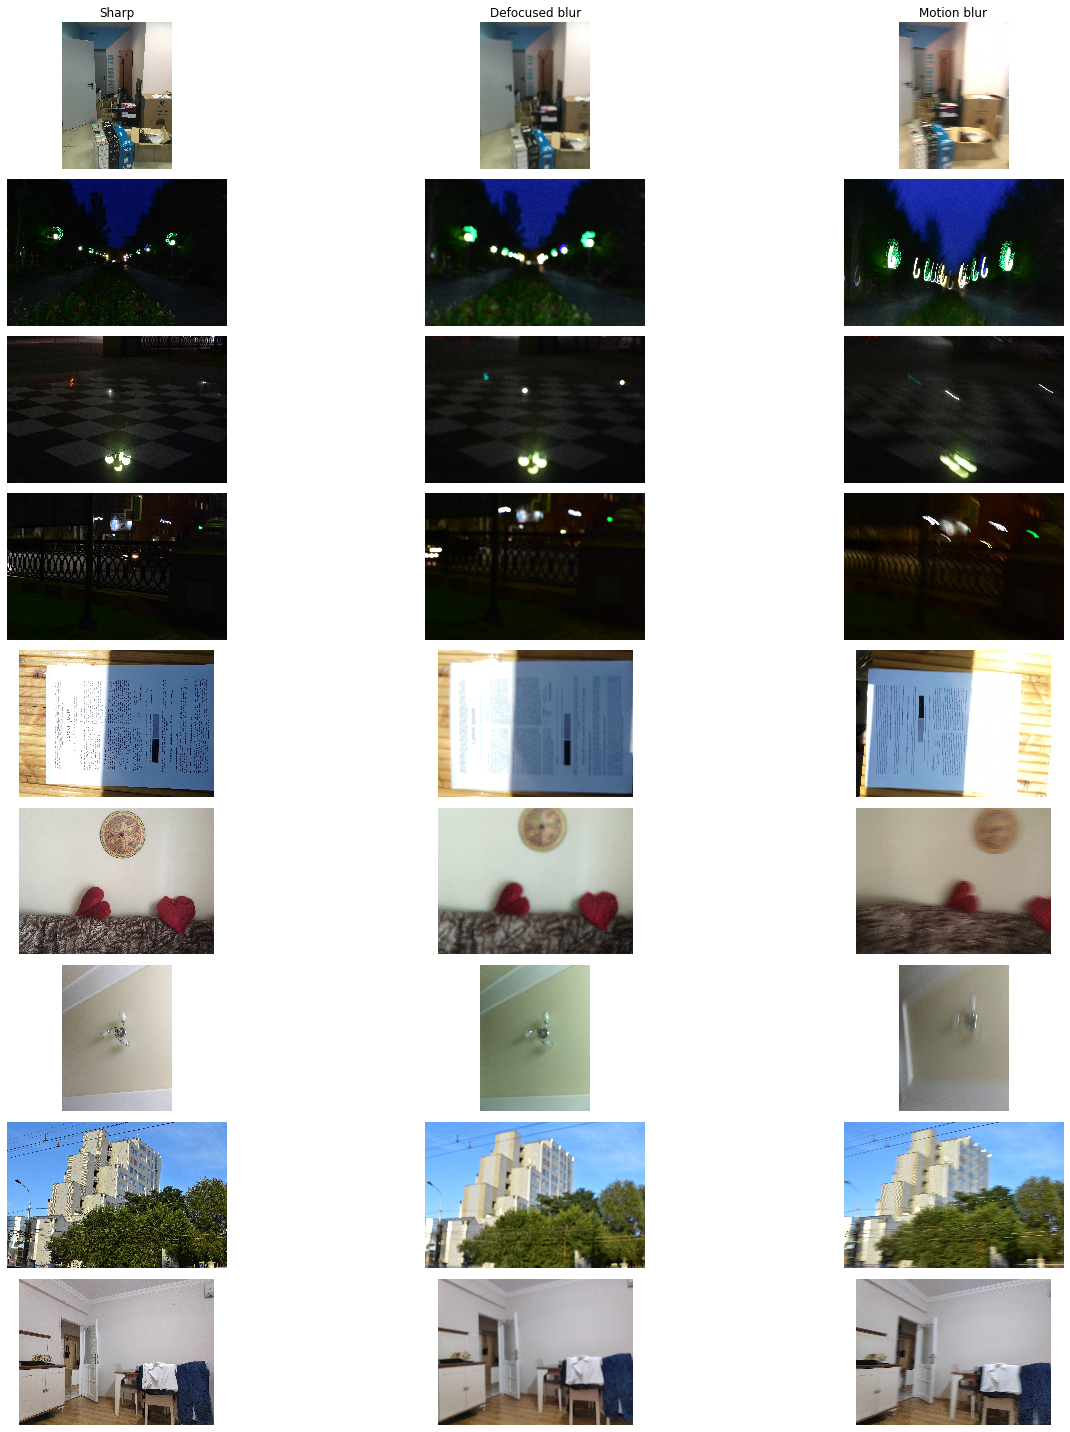

In [40]:
show_data()

## Sử dụng các bộ lọc để hiển thị đặc trưng cạnh của ảnh

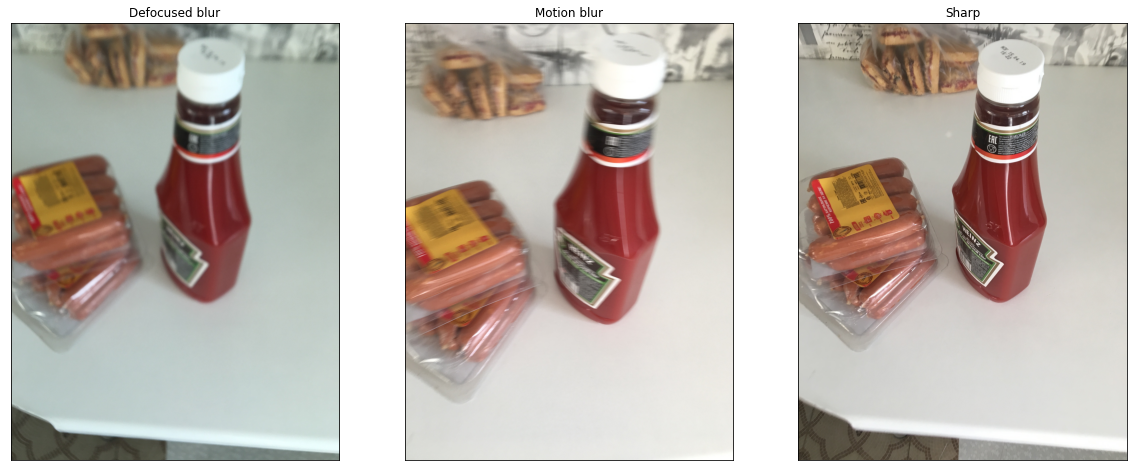

In [41]:
show_images(example_img)

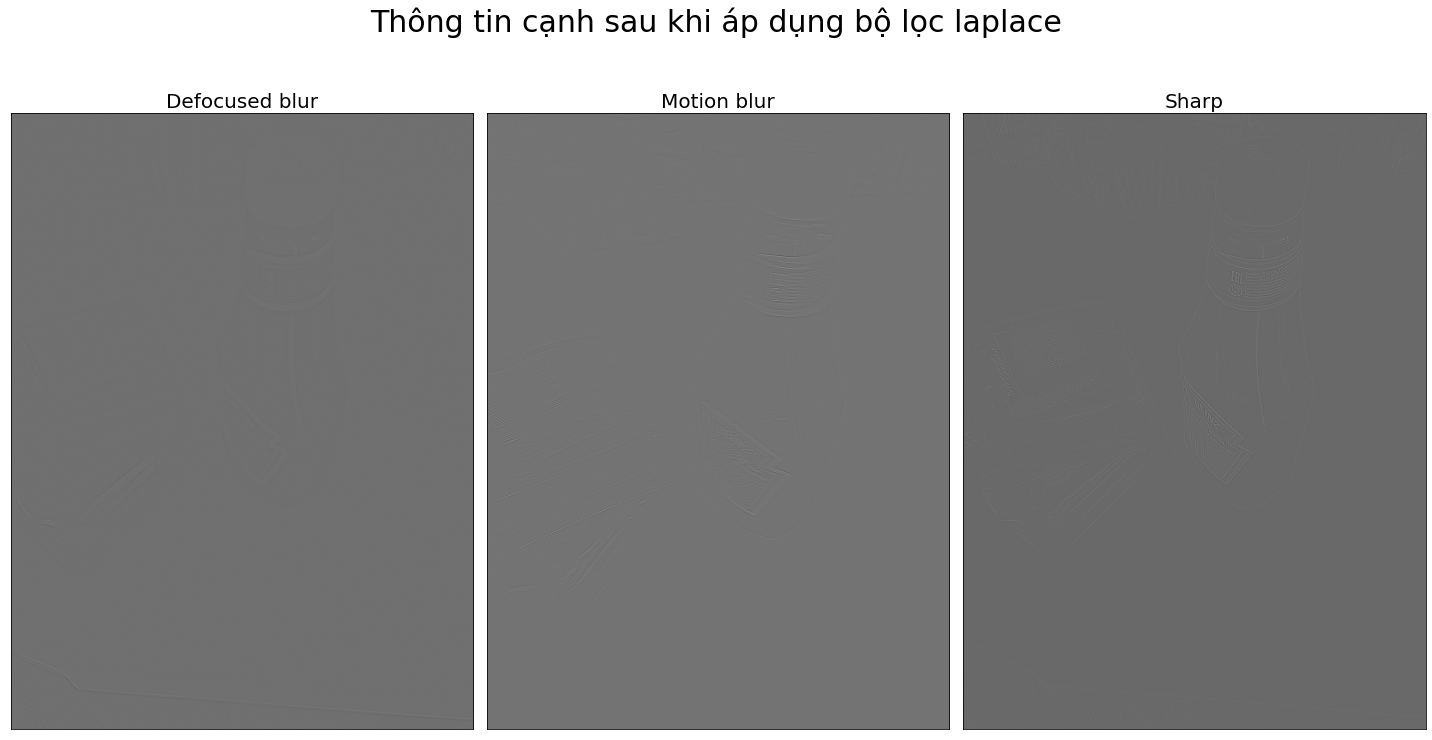

In [42]:
show_images_features(example_img,filter="laplace")

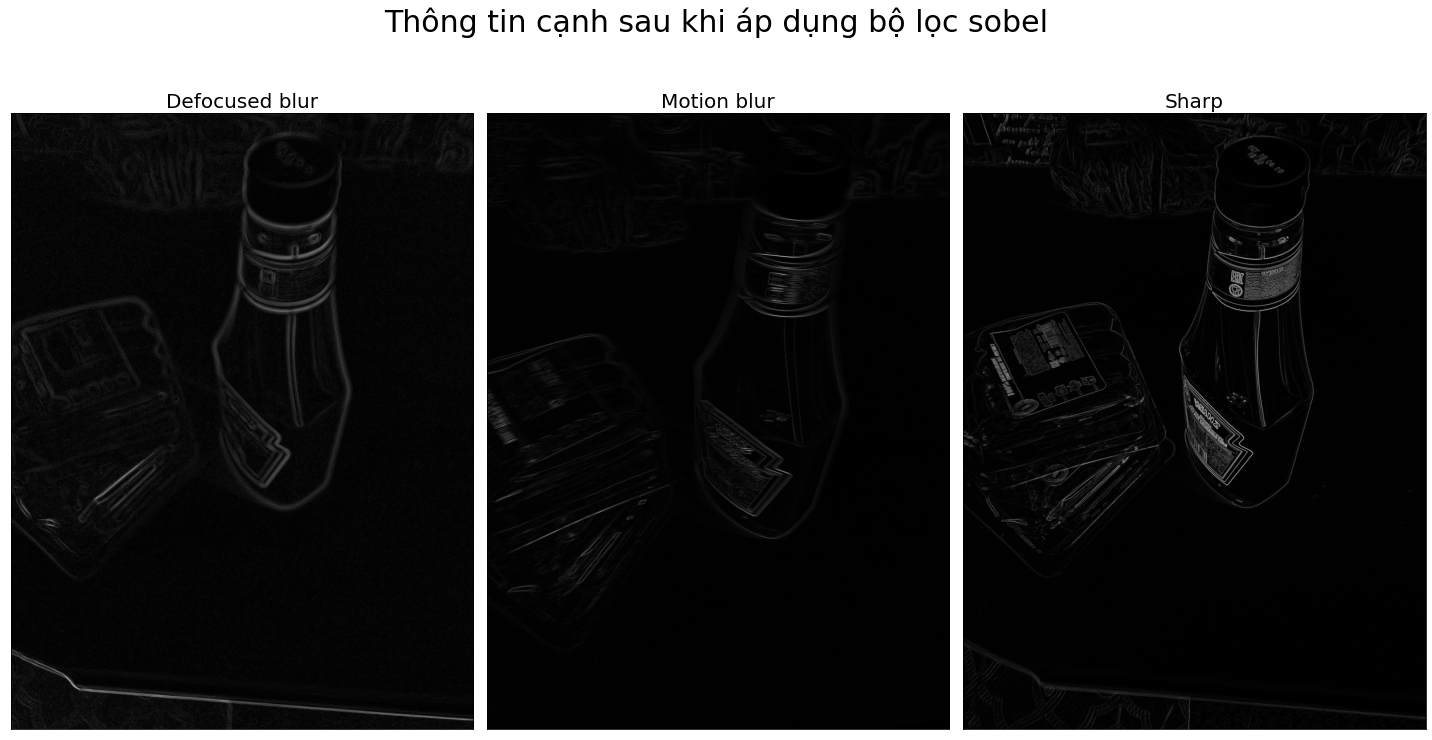

In [43]:
show_images_features(example_img,filter="sobel")

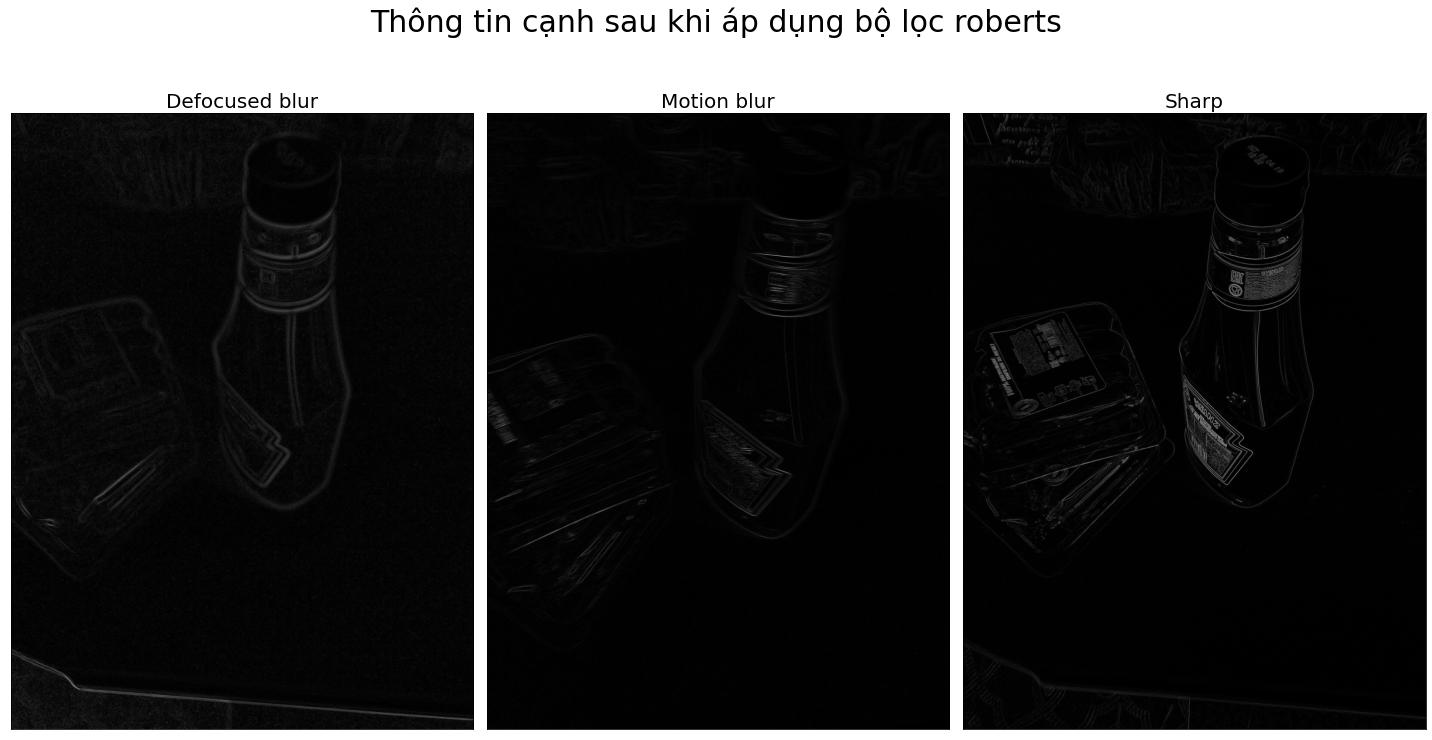

In [44]:
show_images_features(example_img,filter="roberts")

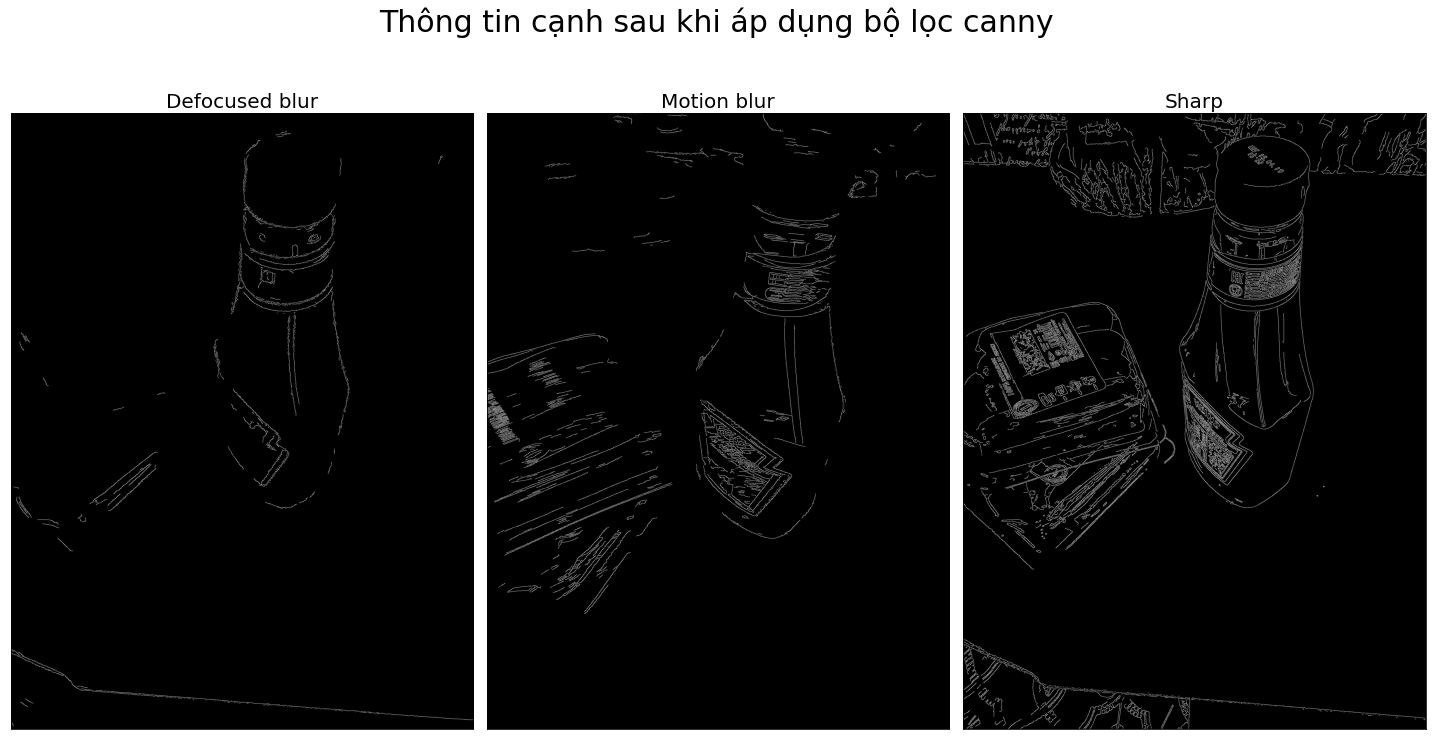

In [45]:
show_images_features(example_img,filter="canny")

## Áp dụng FFT để hiện thị cường độ quang phổ của ảnh

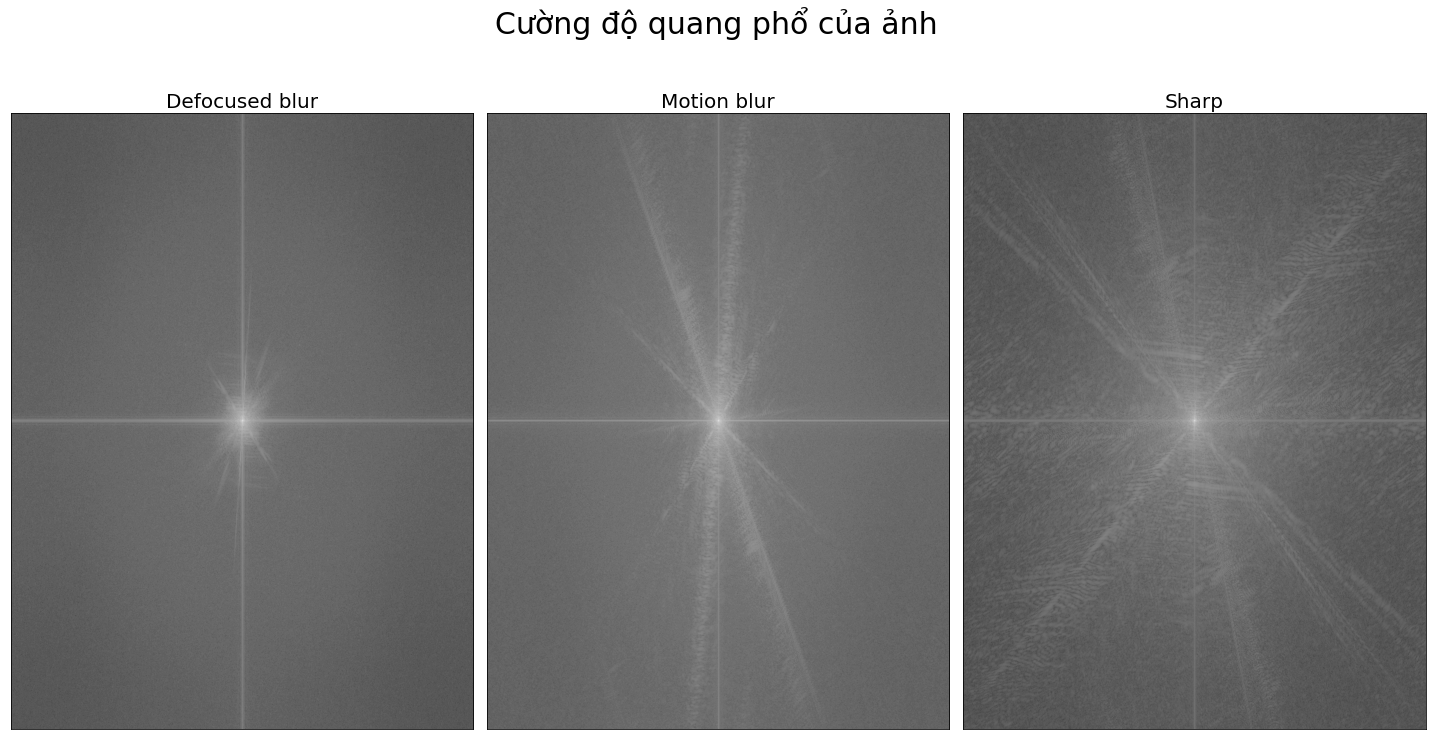

In [46]:
show_images_spectrum(example_img)

# Lấy đặc trưng cạnh

In [47]:
sharp_features = get_data(sharp_dir,sharp_images)
defocused_features = get_data(dblurred_dir,dblurred_images)
motion_blur_features = get_data(mblurred_dir,mblurred_images)

In [48]:
print(len(sharp_features))
print(len(defocused_features))
print(len(motion_blur_features))

350
350
350


In [49]:
sharp_df = pd.DataFrame(sharp_features)
defocused_df = pd.DataFrame(defocused_features)
motion_df = pd.DataFrame(motion_blur_features)

In [50]:
defocused_df

0         1         2   ...        9          10          11
0    0.000300  0.176471  0.006874  ...  0.002807   2.794963  393.724780
1    0.001523  0.439216  0.008265  ...  0.001853   6.012881  467.463439
2    0.001448  0.349020  0.007755  ...  0.000852   4.343427  454.718495
3    0.000446  0.388235  0.006110  ...  0.001696  -1.389926  453.056096
4    0.000206  0.207843  0.005652  ...  0.000506   1.254718  453.017483
..        ...       ...       ...  ...       ...        ...         ...
345  0.000766  0.572549  0.009158  ...  0.003132   8.106328  402.922881
346  0.000946  0.545098  0.010251  ...  0.002635   9.584022  407.164352
347  0.000912  0.368627  0.010788  ...  0.003696   9.588199  415.884071
348  0.000776  0.545098  0.012580  ...  0.016162  15.374914  431.918055
349  0.000346  0.443137  0.006490  ...  0.002370   4.430409  402.934765

[350 rows x 12 columns]

# Thử nghiệm một số mô hình máy học để phân loại

## Trường hợp 1: Phân loại ảnh rõ nét, ảnh mờ do mất nét, ảnh mờ do chuyển động

### Chuẩn bị dữ liệu

In [51]:
all_features = []
all_features.extend(sharp_features)
all_features.extend(defocused_features)
all_features.extend(motion_blur_features)
all_features = np.array(all_features)

label = np.concatenate((np.zeros((len(sharp_features), )), np.ones((len(defocused_features), )), 2*np.ones((len(motion_blur_features), ))), axis=0)

In [52]:
len(all_features)

1050

In [53]:
label.shape

(1050,)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
...     all_features, label, test_size=0.3, stratify = label,random_state = 12)

In [55]:
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = QuantileTransformer()

scaler.fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (735). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)


In [56]:
pd.DataFrame(X_train_scale).head()

0         1         2   ...        9         10        11
0  0.836512  0.926431  0.760218  ...  0.648501  0.726158  0.922343
1  0.373297  0.471390  0.404632  ...  0.562670  0.595368  0.660763
2  0.754768  0.670981  0.776567  ...  0.769755  0.799728  0.543597
3  0.489101  0.869210  0.485014  ...  0.555858  0.589918  0.685286
4  0.818801  0.480018  0.742507  ...  0.732970  0.762943  0.658038

[5 rows x 12 columns]

### Mô hình random forest

In [57]:
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10],
              'n_estimators':[100,500,1000],
             'max_features': ['auto', 'sqrt', 'log2']}

In [58]:
RF_model = GridSearchCV(RandomForestClassifier(),param_grid = param_grid,verbose = 2,refit=True)
RF_model.fit(X_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END ...max_depth=1, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=1, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=1, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=1, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=1, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=1, max_features=auto, n_estimators=500; total time=   0.8s
[CV] END ...max_depth=1, max_features=auto, n_estimators=500; total time=   0.8s
[CV] END ...max_depth=1, max_features=auto, n_estimators=500; total time=   0.8s
[CV] END ...max_depth=1, max_features=auto, n_estimators=500; total time=   0.8s
[CV] END ...max_depth=1, max_features=auto, n_estimators=500; total time=   0.8s
[CV] END ..max_depth=1, max_features=auto, n_estimators=1000; total time=   1.6s
[CV] END ..max_depth=1, max_features=auto, n_es

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500, 1000]},
             verbose=2)

In [59]:
RF_model.best_estimator_

RandomForestClassifier(max_depth=6)

In [60]:
RF_predictions = RF_model.predict(X_test)
print('accuracy = ',accuracy_score(RF_predictions,y_test))

accuracy =  0.7714285714285715


In [61]:
print('Classification_report:\n',classification_report(y_test,RF_predictions))

Classification_report:
               precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       105
         1.0       0.74      0.90      0.81       105
         2.0       0.71      0.54      0.62       105

    accuracy                           0.77       315
   macro avg       0.77      0.77      0.76       315
weighted avg       0.77      0.77      0.76       315



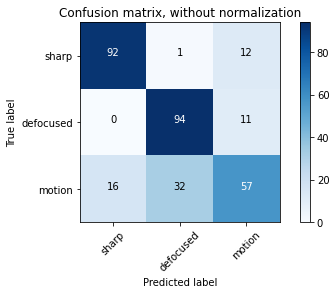

In [62]:
cnf_matrix = confusion_matrix(y_test, RF_predictions)
class_names = ['sharp', 'defocused', 'motion']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

### Mô hình SVM

In [63]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf', 'sigmoid']} 
SVM_model = GridSearchCV(SVC(),param_grid, refit=True, verbose=3)
SVM_model.fit(X_train_scale,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.776 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.755 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.755 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.707 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.728 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.034 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.054 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.007 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.034 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.054 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.748 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=3)

In [64]:
SVM_model.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'sigmoid'}

In [65]:
SVM_predictions = SVM_model.predict(X_test_scale)

In [66]:
print('Classification_report:\n',classification_report(y_test,SVM_predictions))

Classification_report:
               precision    recall  f1-score   support

         0.0       0.84      0.87      0.85       105
         1.0       0.79      0.89      0.83       105
         2.0       0.73      0.62      0.67       105

    accuracy                           0.79       315
   macro avg       0.79      0.79      0.79       315
weighted avg       0.79      0.79      0.79       315



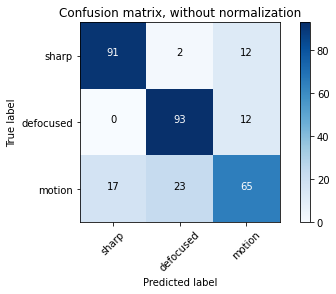

In [67]:
cnf_matrix = confusion_matrix(y_test, SVM_predictions)
class_names = ['sharp', 'defocused', 'motion']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

### Mô hình MLP

In [68]:
param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 
              'solver': ['lbfgs', 'sgd', 'adam'],'learning_rate_init':[0.005,0.001,0.0005]} 
MLP_model = GridSearchCV(MLPClassifier(),param_grid, refit=True, verbose=3)
MLP_model.fit(X_train_scale,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END activation=identity, learning_rate_init=0.005, solver=lbfgs;, score=0.762 total time=   0.3s
[CV 2/5] END activation=identity, learning_rate_init=0.005, solver=lbfgs;, score=0.796 total time=   0.3s
[CV 3/5] END activation=identity, learning_rate_init=0.005, solver=lbfgs;, score=0.776 total time=   0.4s
[CV 4/5] END activation=identity, learning_rate_init=0.005, solver=lbfgs;, score=0.762 total time=   0.3s
[CV 5/5] END activation=identity, learning_rate_init=0.005, solver=lbfgs;, score=0.789 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=identity, learning_rate_init=0.005, solver=sgd;, score=0.755 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=identity, learning_rate_init=0.005, solver=sgd;, score=0.803 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=identity, learning_rate_init=0.005, solver=sgd;, score=0.714 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=identity, learning_rate_init=0.005, solver=sgd;, score=0.728 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=identity, learning_rate_init=0.005, solver=sgd;, score=0.735 total time=   0.4s
[CV 1/5] END activation=identity, learning_rate_init=0.005, solver=adam;, score=0.735 total time=   0.2s
[CV 2/5] END activation=identity, learning_rate_init=0.005, solver=adam;, score=0.796 total time=   0.3s
[CV 3/5] END activation=identity, learning_rate_init=0.005, solver=adam;, score=0.782 total time=   0.2s
[CV 4/5] END activation=identity, learning_rate_init=0.005, solver=adam;, score=0.776 total time=   0.2s
[CV 5/5] END activation=identity, learning_rate_init=0.005, solver=adam;, score=0.776 total time=   0.3s
[CV 1/5] END activation=identity, learning_rate_init=0.001, solver=lbfgs;, score=0.762 total time=   0.3s
[CV 2/5] END activation=identity, learning_rate_init=0.001, solver=lbfgs;, score=0.796 total time=   0.3s
[CV 3/5] END activation=identity, learning_rate_init=0.001, solver=lbfgs;, score=0.776 total time=   0.4s
[CV 4/5] END activation=identity, learning_rate_init=

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=identity, learning_rate_init=0.001, solver=sgd;, score=0.714 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=identity, learning_rate_init=0.001, solver=sgd;, score=0.741 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=identity, learning_rate_init=0.001, solver=sgd;, score=0.762 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=identity, learning_rate_init=0.001, solver=sgd;, score=0.721 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=identity, learning_rate_init=0.001, solver=sgd;, score=0.735 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=identity, learning_rate_init=0.001, solver=adam;, score=0.741 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=identity, learning_rate_init=0.001, solver=adam;, score=0.823 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=identity, learning_rate_init=0.001, solver=adam;, score=0.735 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=identity, learning_rate_init=0.001, solver=adam;, score=0.755 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=identity, learning_rate_init=0.001, solver=adam;, score=0.769 total time=   0.4s
[CV 1/5] END activation=identity, learning_rate_init=0.0005, solver=lbfgs;, score=0.762 total time=   0.3s
[CV 2/5] END activation=identity, learning_rate_init=0.0005, solver=lbfgs;, score=0.796 total time=   0.4s
[CV 3/5] END activation=identity, learning_rate_init=0.0005, solver=lbfgs;, score=0.782 total time=   0.3s
[CV 4/5] END activation=identity, learning_rate_init=0.0005, solver=lbfgs;, score=0.762 total time=   0.3s
[CV 5/5] END activation=identity, learning_rate_init=0.0005, solver=lbfgs;, score=0.789 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=identity, learning_rate_init=0.0005, solver=sgd;, score=0.701 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=identity, learning_rate_init=0.0005, solver=sgd;, score=0.680 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=identity, learning_rate_init=0.0005, solver=sgd;, score=0.735 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=identity, learning_rate_init=0.0005, solver=sgd;, score=0.680 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=identity, learning_rate_init=0.0005, solver=sgd;, score=0.707 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=identity, learning_rate_init=0.0005, solver=adam;, score=0.748 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=identity, learning_rate_init=0.0005, solver=adam;, score=0.816 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=identity, learning_rate_init=0.0005, solver=adam;, score=0.721 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=identity, learning_rate_init=0.0005, solver=adam;, score=0.741 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=identity, learning_rate_init=0.0005, solver=adam;, score=0.741 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, learning_rate_init=0.005, solver=lbfgs;, score=0.803 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=logistic, learning_rate_init=0.005, solver=lbfgs;, score=0.769 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, learning_rate_init=0.005, solver=lbfgs;, score=0.762 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, learning_rate_init=0.005, solver=lbfgs;, score=0.728 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, learning_rate_init=0.005, solver=lbfgs;, score=0.782 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.005, solver=sgd;, score=0.714 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=logistic, learning_rate_init=0.005, solver=sgd;, score=0.707 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=logistic, learning_rate_init=0.005, solver=sgd;, score=0.735 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=logistic, learning_rate_init=0.005, solver=sgd;, score=0.680 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.005, solver=sgd;, score=0.680 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.005, solver=adam;, score=0.755 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=logistic, learning_rate_init=0.005, solver=adam;, score=0.810 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=logistic, learning_rate_init=0.005, solver=adam;, score=0.741 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=logistic, learning_rate_init=0.005, solver=adam;, score=0.762 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.005, solver=adam;, score=0.782 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, learning_rate_init=0.001, solver=lbfgs;, score=0.810 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=logistic, learning_rate_init=0.001, solver=lbfgs;, score=0.789 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, learning_rate_init=0.001, solver=lbfgs;, score=0.748 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, learning_rate_init=0.001, solver=lbfgs;, score=0.735 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, learning_rate_init=0.001, solver=lbfgs;, score=0.748 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.001, solver=sgd;, score=0.667 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=logistic, learning_rate_init=0.001, solver=sgd;, score=0.646 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=logistic, learning_rate_init=0.001, solver=sgd;, score=0.707 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=logistic, learning_rate_init=0.001, solver=sgd;, score=0.660 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.001, solver=sgd;, score=0.673 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.001, solver=adam;, score=0.748 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=logistic, learning_rate_init=0.001, solver=adam;, score=0.755 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=logistic, learning_rate_init=0.001, solver=adam;, score=0.748 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=logistic, learning_rate_init=0.001, solver=adam;, score=0.735 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.001, solver=adam;, score=0.741 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, learning_rate_init=0.0005, solver=lbfgs;, score=0.748 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=logistic, learning_rate_init=0.0005, solver=lbfgs;, score=0.776 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, learning_rate_init=0.0005, solver=lbfgs;, score=0.748 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, learning_rate_init=0.0005, solver=lbfgs;, score=0.735 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, learning_rate_init=0.0005, solver=lbfgs;, score=0.776 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.0005, solver=sgd;, score=0.701 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=logistic, learning_rate_init=0.0005, solver=sgd;, score=0.626 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=logistic, learning_rate_init=0.0005, solver=sgd;, score=0.687 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=logistic, learning_rate_init=0.0005, solver=sgd;, score=0.653 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.0005, solver=sgd;, score=0.653 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.0005, solver=adam;, score=0.762 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=logistic, learning_rate_init=0.0005, solver=adam;, score=0.721 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=logistic, learning_rate_init=0.0005, solver=adam;, score=0.741 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=logistic, learning_rate_init=0.0005, solver=adam;, score=0.680 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.0005, solver=adam;, score=0.714 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, learning_rate_init=0.005, solver=lbfgs;, score=0.816 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, learning_rate_init=0.005, solver=lbfgs;, score=0.755 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=tanh, learning_rate_init=0.005, solver=lbfgs;, score=0.755 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, learning_rate_init=0.005, solver=lbfgs;, score=0.741 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, learning_rate_init=0.005, solver=lbfgs;, score=0.748 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=tanh, learning_rate_init=0.005, solver=sgd;, score=0.748 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=tanh, learning_rate_init=0.005, solver=sgd;, score=0.810 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=tanh, learning_rate_init=0.005, solver=sgd;, score=0.735 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=tanh, learning_rate_init=0.005, solver=sgd;, score=0.735 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=tanh, learning_rate_init=0.005, solver=sgd;, score=0.735 total time=   0.8s
[CV 1/5] END activation=tanh, learning_rate_init=0.005, solver=adam;, score=0.748 total time=   0.4s
[CV 2/5] END activation=tanh, learning_rate_init=0.005, solver=adam;, score=0.803 total time=   0.4s
[CV 3/5] END activation=tanh, learning_rate_init=0.005, solver=adam;, score=0.769 total time=   0.4s
[CV 4/5] END activation=tanh, learning_rate_init=0.005, solver=adam;, score=0.789 total time=   0.6s
[CV 5/5] END activation=tanh, learning_rate_init=0.005, solver=adam;, score=0.769 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, learning_rate_init=0.001, solver=lbfgs;, score=0.776 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, learning_rate_init=0.001, solver=lbfgs;, score=0.735 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=tanh, learning_rate_init=0.001, solver=lbfgs;, score=0.776 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, learning_rate_init=0.001, solver=lbfgs;, score=0.721 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, learning_rate_init=0.001, solver=lbfgs;, score=0.762 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=tanh, learning_rate_init=0.001, solver=sgd;, score=0.728 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=tanh, learning_rate_init=0.001, solver=sgd;, score=0.714 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=tanh, learning_rate_init=0.001, solver=sgd;, score=0.735 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=tanh, learning_rate_init=0.001, solver=sgd;, score=0.694 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=tanh, learning_rate_init=0.001, solver=sgd;, score=0.701 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=tanh, learning_rate_init=0.001, solver=adam;, score=0.748 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=tanh, learning_rate_init=0.001, solver=adam;, score=0.823 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=tanh, learning_rate_init=0.001, solver=adam;, score=0.728 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=tanh, learning_rate_init=0.001, solver=adam;, score=0.769 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=tanh, learning_rate_init=0.001, solver=adam;, score=0.776 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, learning_rate_init=0.0005, solver=lbfgs;, score=0.762 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, learning_rate_init=0.0005, solver=lbfgs;, score=0.748 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=tanh, learning_rate_init=0.0005, solver=lbfgs;, score=0.741 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, learning_rate_init=0.0005, solver=lbfgs;, score=0.741 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, learning_rate_init=0.0005, solver=lbfgs;, score=0.769 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=tanh, learning_rate_init=0.0005, solver=sgd;, score=0.694 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=tanh, learning_rate_init=0.0005, solver=sgd;, score=0.687 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=tanh, learning_rate_init=0.0005, solver=sgd;, score=0.721 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=tanh, learning_rate_init=0.0005, solver=sgd;, score=0.667 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=tanh, learning_rate_init=0.0005, solver=sgd;, score=0.687 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=tanh, learning_rate_init=0.0005, solver=adam;, score=0.748 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=tanh, learning_rate_init=0.0005, solver=adam;, score=0.816 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=tanh, learning_rate_init=0.0005, solver=adam;, score=0.728 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=tanh, learning_rate_init=0.0005, solver=adam;, score=0.755 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=tanh, learning_rate_init=0.0005, solver=adam;, score=0.741 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=relu, learning_rate_init=0.005, solver=lbfgs;, score=0.776 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, learning_rate_init=0.005, solver=lbfgs;, score=0.748 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=relu, learning_rate_init=0.005, solver=lbfgs;, score=0.748 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, learning_rate_init=0.005, solver=lbfgs;, score=0.741 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, learning_rate_init=0.005, solver=lbfgs;, score=0.755 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=relu, learning_rate_init=0.005, solver=sgd;, score=0.755 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.005, solver=sgd;, score=0.796 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=relu, learning_rate_init=0.005, solver=sgd;, score=0.762 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=relu, learning_rate_init=0.005, solver=sgd;, score=0.748 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=relu, learning_rate_init=0.005, solver=sgd;, score=0.748 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=relu, learning_rate_init=0.005, solver=adam;, score=0.769 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.005, solver=adam;, score=0.816 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=relu, learning_rate_init=0.005, solver=adam;, score=0.755 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=relu, learning_rate_init=0.005, solver=adam;, score=0.728 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=relu, learning_rate_init=0.005, solver=adam;, score=0.776 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=relu, learning_rate_init=0.001, solver=lbfgs;, score=0.782 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, learning_rate_init=0.001, solver=lbfgs;, score=0.789 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=relu, learning_rate_init=0.001, solver=lbfgs;, score=0.755 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, learning_rate_init=0.001, solver=lbfgs;, score=0.701 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, learning_rate_init=0.001, solver=lbfgs;, score=0.810 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=relu, learning_rate_init=0.001, solver=sgd;, score=0.701 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.001, solver=sgd;, score=0.680 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=relu, learning_rate_init=0.001, solver=sgd;, score=0.748 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=relu, learning_rate_init=0.001, solver=sgd;, score=0.687 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=relu, learning_rate_init=0.001, solver=sgd;, score=0.707 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=relu, learning_rate_init=0.001, solver=adam;, score=0.769 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.001, solver=adam;, score=0.816 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=relu, learning_rate_init=0.001, solver=adam;, score=0.748 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=relu, learning_rate_init=0.001, solver=adam;, score=0.769 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=relu, learning_rate_init=0.001, solver=adam;, score=0.776 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=relu, learning_rate_init=0.0005, solver=lbfgs;, score=0.755 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, learning_rate_init=0.0005, solver=lbfgs;, score=0.735 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=relu, learning_rate_init=0.0005, solver=lbfgs;, score=0.755 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, learning_rate_init=0.0005, solver=lbfgs;, score=0.721 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, learning_rate_init=0.0005, solver=lbfgs;, score=0.782 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=relu, learning_rate_init=0.0005, solver=sgd;, score=0.701 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.0005, solver=sgd;, score=0.605 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=relu, learning_rate_init=0.0005, solver=sgd;, score=0.667 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=relu, learning_rate_init=0.0005, solver=sgd;, score=0.653 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=relu, learning_rate_init=0.0005, solver=sgd;, score=0.626 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=relu, learning_rate_init=0.0005, solver=adam;, score=0.762 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.0005, solver=adam;, score=0.816 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=relu, learning_rate_init=0.0005, solver=adam;, score=0.728 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=relu, learning_rate_init=0.0005, solver=adam;, score=0.735 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=relu, learning_rate_init=0.0005, solver=adam;, score=0.748 total time=   0.5s


GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'learning_rate_init': [0.005, 0.001, 0.0005],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=3)

In [69]:
MLP_model.best_params_

{'activation': 'identity', 'learning_rate_init': 0.0005, 'solver': 'lbfgs'}

In [70]:
MLP_predictions = MLP_model.predict(X_test_scale)

In [71]:
print('Classification_report:\n',classification_report(y_test,MLP_predictions))

Classification_report:
               precision    recall  f1-score   support

         0.0       0.86      0.86      0.86       105
         1.0       0.80      0.89      0.84       105
         2.0       0.73      0.66      0.69       105

    accuracy                           0.80       315
   macro avg       0.80      0.80      0.80       315
weighted avg       0.80      0.80      0.80       315



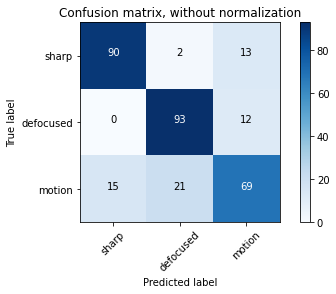

In [72]:
cnf_matrix = confusion_matrix(y_test, MLP_predictions)
class_names = ['sharp', 'defocused', 'motion']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

## Trường hợp 2: Phân loại ảnh rõ nét và ảnh mờ (bao gồm 2 loại ảnh mờ trong tập dữ liệu)

### Chuẩn bị dữ liệu

In [73]:
all_features1 = []
all_features1.extend(sharp_features)
all_features1.extend(defocused_features)
all_features1.extend(motion_blur_features)
all_features1 = np.array(all_features1)

label1 = np.concatenate((np.zeros((len(sharp_features), )), np.ones((len(defocused_features) + len(motion_blur_features), ))), axis=0)

In [74]:
all_features1.shape

(1050, 12)

In [75]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
...     all_features1, label1, test_size=0.3, stratify = label1,random_state = 12)

In [76]:
scaler1 = QuantileTransformer()
scaler1.fit(X_train1)
X_train1_scale = scaler1.transform(X_train1)
X_test1_scale = scaler1.transform(X_test1)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (735). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)


###Mô hình Random Forest

In [77]:
param_grid = {'max_depth':[1,2,3,4,5,6,7,8,9,10],
              'n_estimators':[100,500,1000],
             'max_features': ['auto', 'sqrt', 'log2']}

In [78]:
RF_model1 = GridSearchCV(RandomForestClassifier(),param_grid = param_grid,verbose = 2,refit=True)
RF_model1.fit(X_train1,y_train1)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] END ...max_depth=1, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=1, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=1, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=1, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=1, max_features=auto, n_estimators=100; total time=   0.2s
[CV] END ...max_depth=1, max_features=auto, n_estimators=500; total time=   0.8s
[CV] END ...max_depth=1, max_features=auto, n_estimators=500; total time=   0.8s
[CV] END ...max_depth=1, max_features=auto, n_estimators=500; total time=   0.8s
[CV] END ...max_depth=1, max_features=auto, n_estimators=500; total time=   0.8s
[CV] END ...max_depth=1, max_features=auto, n_estimators=500; total time=   0.8s
[CV] END ..max_depth=1, max_features=auto, n_estimators=1000; total time=   1.6s
[CV] END ..max_depth=1, max_features=auto, n_es

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 500, 1000]},
             verbose=2)

In [79]:
RF_model1.best_estimator_

RandomForestClassifier(max_depth=4, n_estimators=500)

In [80]:
RF_predictions1 = RF_model1.predict(X_test1)
print('accuracy = ',accuracy_score(RF_predictions1,y_test1))

accuracy =  0.9301587301587302


In [81]:
print('Classification_report:\n',classification_report(y_test1,RF_predictions1))

Classification_report:
               precision    recall  f1-score   support

         0.0       0.91      0.88      0.89       105
         1.0       0.94      0.96      0.95       210

    accuracy                           0.93       315
   macro avg       0.93      0.92      0.92       315
weighted avg       0.93      0.93      0.93       315



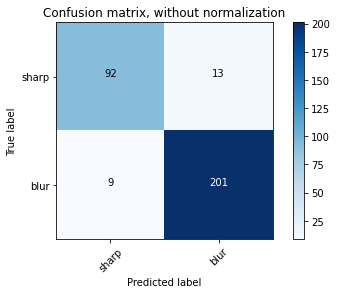

In [82]:
cnf_matrix = confusion_matrix(y_test1, RF_predictions1)
class_names = ['sharp', 'blur']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

### Mô hình SVM

In [83]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': ['auto','scale'], 'kernel': ['rbf', 'sigmoid']} 
SVM_model1 = GridSearchCV(SVC(),param_grid, refit=True, verbose=3)
SVM_model1.fit(X_train1_scale,y_train1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.925 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.891 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.918 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.884 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.830 total time=   0.0s
[CV 1/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.925 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.871 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.898 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.884 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.803 total time=   0.0s
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.918 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['rbf', 'sigmoid']},
             verbose=3)

In [84]:
SVM_model1.best_params_

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

In [85]:
SVM_predictions1 = SVM_model1.predict(X_test1_scale)

In [86]:
print('Classification_report:\n',classification_report(y_test1,SVM_predictions1))

Classification_report:
               precision    recall  f1-score   support

         0.0       0.89      0.88      0.88       105
         1.0       0.94      0.95      0.94       210

    accuracy                           0.92       315
   macro avg       0.92      0.91      0.91       315
weighted avg       0.92      0.92      0.92       315



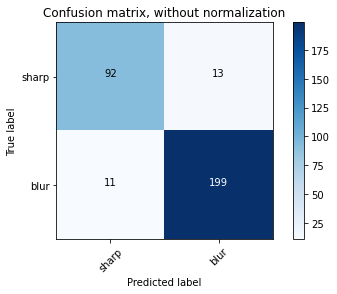

In [87]:
cnf_matrix = confusion_matrix(y_test1, SVM_predictions1)
class_names = ['sharp', 'blur']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

### Mô hình MLP

In [88]:
param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 
              'solver': ['lbfgs', 'sgd', 'adam'],'learning_rate_init':[0.005,0.001,0.0005]} 
MLP_model1 = GridSearchCV(MLPClassifier(),param_grid, refit=True, verbose=3)
MLP_model1.fit(X_train1_scale,y_train1)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END activation=identity, learning_rate_init=0.005, solver=lbfgs;, score=0.912 total time=   0.2s
[CV 2/5] END activation=identity, learning_rate_init=0.005, solver=lbfgs;, score=0.905 total time=   0.1s
[CV 3/5] END activation=identity, learning_rate_init=0.005, solver=lbfgs;, score=0.912 total time=   0.1s
[CV 4/5] END activation=identity, learning_rate_init=0.005, solver=lbfgs;, score=0.918 total time=   0.1s
[CV 5/5] END activation=identity, learning_rate_init=0.005, solver=lbfgs;, score=0.830 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=identity, learning_rate_init=0.005, solver=sgd;, score=0.918 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=identity, learning_rate_init=0.005, solver=sgd;, score=0.878 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=identity, learning_rate_init=0.005, solver=sgd;, score=0.912 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=identity, learning_rate_init=0.005, solver=sgd;, score=0.884 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=identity, learning_rate_init=0.005, solver=sgd;, score=0.816 total time=   0.5s
[CV 1/5] END activation=identity, learning_rate_init=0.005, solver=adam;, score=0.918 total time=   0.3s
[CV 2/5] END activation=identity, learning_rate_init=0.005, solver=adam;, score=0.884 total time=   0.2s
[CV 3/5] END activation=identity, learning_rate_init=0.005, solver=adam;, score=0.925 total time=   0.3s
[CV 4/5] END activation=identity, learning_rate_init=0.005, solver=adam;, score=0.878 total time=   0.2s
[CV 5/5] END activation=identity, learning_rate_init=0.005, solver=adam;, score=0.823 total time=   0.2s
[CV 1/5] END activation=identity, learning_rate_init=0.001, solver=lbfgs;, score=0.912 total time=   0.1s
[CV 2/5] END activation=identity, learning_rate_init=0.001, solver=lbfgs;, score=0.905 total time=   0.1s
[CV 3/5] END activation=identity, learning_rate_init=0.001, solver=lbfgs;, score=0.912 total time=   0.1s
[CV 4/5] END activation=identity, learning_rate_init=

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=identity, learning_rate_init=0.001, solver=sgd;, score=0.918 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=identity, learning_rate_init=0.001, solver=sgd;, score=0.891 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=identity, learning_rate_init=0.001, solver=sgd;, score=0.905 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=identity, learning_rate_init=0.001, solver=sgd;, score=0.878 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=identity, learning_rate_init=0.001, solver=sgd;, score=0.837 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=identity, learning_rate_init=0.001, solver=adam;, score=0.912 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=identity, learning_rate_init=0.001, solver=adam;, score=0.884 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=identity, learning_rate_init=0.001, solver=adam;, score=0.925 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=identity, learning_rate_init=0.001, solver=adam;, score=0.891 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=identity, learning_rate_init=0.001, solver=adam;, score=0.823 total time=   0.6s
[CV 1/5] END activation=identity, learning_rate_init=0.0005, solver=lbfgs;, score=0.912 total time=   0.1s
[CV 2/5] END activation=identity, learning_rate_init=0.0005, solver=lbfgs;, score=0.905 total time=   0.1s
[CV 3/5] END activation=identity, learning_rate_init=0.0005, solver=lbfgs;, score=0.912 total time=   0.1s
[CV 4/5] END activation=identity, learning_rate_init=0.0005, solver=lbfgs;, score=0.918 total time=   0.1s
[CV 5/5] END activation=identity, learning_rate_init=0.0005, solver=lbfgs;, score=0.830 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=identity, learning_rate_init=0.0005, solver=sgd;, score=0.898 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=identity, learning_rate_init=0.0005, solver=sgd;, score=0.871 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=identity, learning_rate_init=0.0005, solver=sgd;, score=0.912 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=identity, learning_rate_init=0.0005, solver=sgd;, score=0.891 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=identity, learning_rate_init=0.0005, solver=sgd;, score=0.823 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=identity, learning_rate_init=0.0005, solver=adam;, score=0.918 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=identity, learning_rate_init=0.0005, solver=adam;, score=0.878 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=identity, learning_rate_init=0.0005, solver=adam;, score=0.918 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=identity, learning_rate_init=0.0005, solver=adam;, score=0.891 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=identity, learning_rate_init=0.0005, solver=adam;, score=0.823 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, learning_rate_init=0.005, solver=lbfgs;, score=0.878 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=logistic, learning_rate_init=0.005, solver=lbfgs;, score=0.857 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, learning_rate_init=0.005, solver=lbfgs;, score=0.918 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, learning_rate_init=0.005, solver=lbfgs;, score=0.898 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, learning_rate_init=0.005, solver=lbfgs;, score=0.816 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.005, solver=sgd;, score=0.898 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=logistic, learning_rate_init=0.005, solver=sgd;, score=0.857 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=logistic, learning_rate_init=0.005, solver=sgd;, score=0.898 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=logistic, learning_rate_init=0.005, solver=sgd;, score=0.857 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.005, solver=sgd;, score=0.810 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.005, solver=adam;, score=0.918 total time=   1.0s
[CV 2/5] END activation=logistic, learning_rate_init=0.005, solver=adam;, score=0.884 total time=   0.6s
[CV 3/5] END activation=logistic, learning_rate_init=0.005, solver=adam;, score=0.918 total time=   0.9s
[CV 4/5] END activation=logistic, learning_rate_init=0.005, solver=adam;, score=0.891 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.005, solver=adam;, score=0.823 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, learning_rate_init=0.001, solver=lbfgs;, score=0.837 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=logistic, learning_rate_init=0.001, solver=lbfgs;, score=0.864 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, learning_rate_init=0.001, solver=lbfgs;, score=0.891 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, learning_rate_init=0.001, solver=lbfgs;, score=0.932 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, learning_rate_init=0.001, solver=lbfgs;, score=0.837 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.001, solver=sgd;, score=0.667 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=logistic, learning_rate_init=0.001, solver=sgd;, score=0.667 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=logistic, learning_rate_init=0.001, solver=sgd;, score=0.667 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=logistic, learning_rate_init=0.001, solver=sgd;, score=0.667 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.001, solver=sgd;, score=0.667 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.001, solver=adam;, score=0.918 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=logistic, learning_rate_init=0.001, solver=adam;, score=0.878 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=logistic, learning_rate_init=0.001, solver=adam;, score=0.918 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=logistic, learning_rate_init=0.001, solver=adam;, score=0.884 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.001, solver=adam;, score=0.823 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, learning_rate_init=0.0005, solver=lbfgs;, score=0.912 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=logistic, learning_rate_init=0.0005, solver=lbfgs;, score=0.850 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, learning_rate_init=0.0005, solver=lbfgs;, score=0.912 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, learning_rate_init=0.0005, solver=lbfgs;, score=0.898 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, learning_rate_init=0.0005, solver=lbfgs;, score=0.844 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.0005, solver=sgd;, score=0.667 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=logistic, learning_rate_init=0.0005, solver=sgd;, score=0.667 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=logistic, learning_rate_init=0.0005, solver=sgd;, score=0.667 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=logistic, learning_rate_init=0.0005, solver=sgd;, score=0.667 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.0005, solver=sgd;, score=0.667 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=logistic, learning_rate_init=0.0005, solver=adam;, score=0.925 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=logistic, learning_rate_init=0.0005, solver=adam;, score=0.891 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=logistic, learning_rate_init=0.0005, solver=adam;, score=0.912 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=logistic, learning_rate_init=0.0005, solver=adam;, score=0.878 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=logistic, learning_rate_init=0.0005, solver=adam;, score=0.837 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, learning_rate_init=0.005, solver=lbfgs;, score=0.912 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, learning_rate_init=0.005, solver=lbfgs;, score=0.891 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=tanh, learning_rate_init=0.005, solver=lbfgs;, score=0.891 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, learning_rate_init=0.005, solver=lbfgs;, score=0.905 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, learning_rate_init=0.005, solver=lbfgs;, score=0.844 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=tanh, learning_rate_init=0.005, solver=sgd;, score=0.925 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=tanh, learning_rate_init=0.005, solver=sgd;, score=0.864 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=tanh, learning_rate_init=0.005, solver=sgd;, score=0.912 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=tanh, learning_rate_init=0.005, solver=sgd;, score=0.878 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=tanh, learning_rate_init=0.005, solver=sgd;, score=0.816 total time=   1.1s
[CV 1/5] END activation=tanh, learning_rate_init=0.005, solver=adam;, score=0.912 total time=   0.5s
[CV 2/5] END activation=tanh, learning_rate_init=0.005, solver=adam;, score=0.878 total time=   0.3s
[CV 3/5] END activation=tanh, learning_rate_init=0.005, solver=adam;, score=0.932 total time=   0.9s
[CV 4/5] END activation=tanh, learning_rate_init=0.005, solver=adam;, score=0.891 total time=   0.4s
[CV 5/5] END activation=tanh, learning_rate_init=0.005, solver=adam;, score=0.830 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, learning_rate_init=0.001, solver=lbfgs;, score=0.925 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, learning_rate_init=0.001, solver=lbfgs;, score=0.850 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=tanh, learning_rate_init=0.001, solver=lbfgs;, score=0.898 total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, learning_rate_init=0.001, solver=lbfgs;, score=0.891 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, learning_rate_init=0.001, solver=lbfgs;, score=0.830 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=tanh, learning_rate_init=0.001, solver=sgd;, score=0.925 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=tanh, learning_rate_init=0.001, solver=sgd;, score=0.891 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=tanh, learning_rate_init=0.001, solver=sgd;, score=0.918 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=tanh, learning_rate_init=0.001, solver=sgd;, score=0.884 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=tanh, learning_rate_init=0.001, solver=sgd;, score=0.816 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=tanh, learning_rate_init=0.001, solver=adam;, score=0.912 total time=   1.2s
[CV 2/5] END activation=tanh, learning_rate_init=0.001, solver=adam;, score=0.884 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=tanh, learning_rate_init=0.001, solver=adam;, score=0.918 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=tanh, learning_rate_init=0.001, solver=adam;, score=0.891 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=tanh, learning_rate_init=0.001, solver=adam;, score=0.823 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=tanh, learning_rate_init=0.0005, solver=lbfgs;, score=0.939 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=tanh, learning_rate_init=0.0005, solver=lbfgs;, score=0.871 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=tanh, learning_rate_init=0.0005, solver=lbfgs;, score=0.891 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=tanh, learning_rate_init=0.0005, solver=lbfgs;, score=0.918 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, learning_rate_init=0.0005, solver=lbfgs;, score=0.850 total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=tanh, learning_rate_init=0.0005, solver=sgd;, score=0.912 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=tanh, learning_rate_init=0.0005, solver=sgd;, score=0.871 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=tanh, learning_rate_init=0.0005, solver=sgd;, score=0.857 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=tanh, learning_rate_init=0.0005, solver=sgd;, score=0.878 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=tanh, learning_rate_init=0.0005, solver=sgd;, score=0.823 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=tanh, learning_rate_init=0.0005, solver=adam;, score=0.925 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=tanh, learning_rate_init=0.0005, solver=adam;, score=0.878 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=tanh, learning_rate_init=0.0005, solver=adam;, score=0.912 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=tanh, learning_rate_init=0.0005, solver=adam;, score=0.891 total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=tanh, learning_rate_init=0.0005, solver=adam;, score=0.823 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=relu, learning_rate_init=0.005, solver=lbfgs;, score=0.898 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, learning_rate_init=0.005, solver=lbfgs;, score=0.932 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=relu, learning_rate_init=0.005, solver=lbfgs;, score=0.884 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, learning_rate_init=0.005, solver=lbfgs;, score=0.905 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, learning_rate_init=0.005, solver=lbfgs;, score=0.844 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=relu, learning_rate_init=0.005, solver=sgd;, score=0.925 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.005, solver=sgd;, score=0.884 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=relu, learning_rate_init=0.005, solver=sgd;, score=0.912 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=relu, learning_rate_init=0.005, solver=sgd;, score=0.884 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=relu, learning_rate_init=0.005, solver=sgd;, score=0.823 total time=   0.7s
[CV 1/5] END activation=relu, learning_rate_init=0.005, solver=adam;, score=0.925 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.005, solver=adam;, score=0.905 total time=   0.7s
[CV 3/5] END activation=relu, learning_rate_init=0.005, solver=adam;, score=0.946 total time=   0.8s
[CV 4/5] END activation=relu, learning_rate_init=0.005, solver=adam;, score=0.891 total time=   0.2s
[CV 5/5] END activation=relu, learning_rate_init=0.005, solver=adam;, score=0.837 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=relu, learning_rate_init=0.001, solver=lbfgs;, score=0.912 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, learning_rate_init=0.001, solver=lbfgs;, score=0.878 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=relu, learning_rate_init=0.001, solver=lbfgs;, score=0.925 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, learning_rate_init=0.001, solver=lbfgs;, score=0.925 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, learning_rate_init=0.001, solver=lbfgs;, score=0.844 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=relu, learning_rate_init=0.001, solver=sgd;, score=0.912 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.001, solver=sgd;, score=0.878 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=relu, learning_rate_init=0.001, solver=sgd;, score=0.891 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=relu, learning_rate_init=0.001, solver=sgd;, score=0.891 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=relu, learning_rate_init=0.001, solver=sgd;, score=0.816 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=relu, learning_rate_init=0.001, solver=adam;, score=0.918 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.001, solver=adam;, score=0.898 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=relu, learning_rate_init=0.001, solver=adam;, score=0.912 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=relu, learning_rate_init=0.001, solver=adam;, score=0.891 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=relu, learning_rate_init=0.001, solver=adam;, score=0.830 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=relu, learning_rate_init=0.0005, solver=lbfgs;, score=0.918 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=relu, learning_rate_init=0.0005, solver=lbfgs;, score=0.905 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=relu, learning_rate_init=0.0005, solver=lbfgs;, score=0.898 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=relu, learning_rate_init=0.0005, solver=lbfgs;, score=0.912 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=relu, learning_rate_init=0.0005, solver=lbfgs;, score=0.850 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=relu, learning_rate_init=0.0005, solver=sgd;, score=0.905 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.0005, solver=sgd;, score=0.864 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=relu, learning_rate_init=0.0005, solver=sgd;, score=0.850 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=relu, learning_rate_init=0.0005, solver=sgd;, score=0.884 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=relu, learning_rate_init=0.0005, solver=sgd;, score=0.816 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 1/5] END activation=relu, learning_rate_init=0.0005, solver=adam;, score=0.918 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 2/5] END activation=relu, learning_rate_init=0.0005, solver=adam;, score=0.871 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 3/5] END activation=relu, learning_rate_init=0.0005, solver=adam;, score=0.918 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 4/5] END activation=relu, learning_rate_init=0.0005, solver=adam;, score=0.884 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


[CV 5/5] END activation=relu, learning_rate_init=0.0005, solver=adam;, score=0.830 total time=   0.7s


GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'learning_rate_init': [0.005, 0.001, 0.0005],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=3)

In [89]:
MLP_model1.best_params_

{'activation': 'relu', 'learning_rate_init': 0.005, 'solver': 'adam'}

In [90]:
MLP_predictions1 = MLP_model1.predict(X_test1_scale)

In [91]:
print('Classification_report:\n',classification_report(y_test1,MLP_predictions1))

Classification_report:
               precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       105
         1.0       0.94      0.95      0.95       210

    accuracy                           0.93       315
   macro avg       0.92      0.91      0.92       315
weighted avg       0.93      0.93      0.93       315



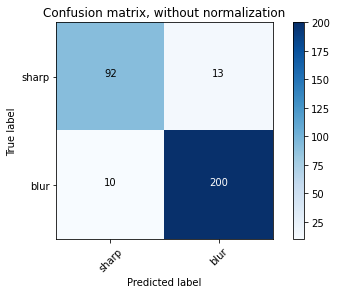

In [92]:
cnf_matrix = confusion_matrix(y_test1, MLP_predictions1)
class_names = ['sharp', 'blur']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

In [93]:
from joblib import dump, load

In [94]:
dump(MLP_model, 'mlp.joblib') 
dump(SVM_model,'svm.joblib')
dump(RF_model,'rf.joblib')
dump(MLP_model1, 'mlp1.joblib') 
dump(SVM_model1,'svm1.joblib')
dump(RF_model1,'rf1.joblib')
dump(scaler,'scaler.joblib')
dump(scaler1,'scaler1.joblib')

['scaler1.joblib']